In [52]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow_decision_forests as tfdf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from tensorflow import python as tf_python
from sklearn.metrics import confusion_matrix,classification_report
import scikitplot as skplt

%matplotlib inline

In [53]:
#loads in files for signal and background
file_sig = uproot.open("mc16e_signal.root")
file_back = uproot.open("mc16e_ttbar.root")

#Sets trees of files to variables
tree_sig = file_sig["nominal"]
tree_back = file_back["nominal"]

#Prints number of entries for each tree
print(f'Signal tree entries: {tree_sig.num_entries}')
print(f'Background tree entries: {tree_back.num_entries}')

Signal tree entries: 3319
Background tree entries: 3531


In [54]:
#Shows contents of each tree
#tree_sig.show()
#tree_back.show()

In [55]:
muonStats_sig = tree_sig.arrays(['mu_pt', 'mu_eta', 'mu_phi'])
jetStats_sig = tree_sig.arrays(['jet_pt', 'jet_eta', 'jet_phi'])
muonStats_back = tree_back.arrays(['mu_pt', 'mu_eta', 'mu_phi'])
jetStats_back = tree_back.arrays(['jet_pt', 'jet_eta', 'jet_phi'])

In [56]:
print(np.concatenate(np.array(muonStats_sig['mu_pt']), axis = 0))

[109464.52   65954.625 148726.    ...  53041.37   58756.44   56119.04 ]


In [57]:
#plt.hist(np.concatenate(muonStats_sig['mu_pt'], axis = 0),bins=np.linspace(0,450000,101),label='Signal', histtype='step')
#plt.hist(np.concatenate(muonStats_back['mu_pt'], axis = 0),bins=np.linspace(0,450000,101),label='Background', histtype='step')
#plt.xlabel(r'Muon $p_{T}$ [GeV]')
#plt.ylabel('Count')
#plt.legend()
#plt.show()

In [58]:
print(tree_sig.keys(filter_name="/(ljet|mu)_(pt|eta|phi)/"))
allStats_sig = tree_sig.arrays(filter_name="/(ljet|mu)_(pt|eta|phi)/", library = 'pd')
allStats_back = tree_back.arrays(filter_name="/(ljet|mu)_(pt|eta|phi)/", library = 'pd')
muonStats_sig = allStats_sig[0];
jetStats_sig = allStats_sig[1];
muonStats_back = allStats_back[0];
jetStats_back = allStats_back[1];

print(allStats_sig);

['mu_pt', 'mu_eta', 'mu_phi', 'ljet_pt', 'ljet_eta', 'ljet_phi', 'ljet_pt_cand', 'ljet_eta_cand', 'ljet_phi_cand']
(                        mu_pt    mu_eta    mu_phi   ljet_pt_cand  \
entry subentry                                                     
0     0         109464.523438  0.752634 -0.603566  274842.875000   
1     0          65954.625000  0.954476  0.651902  212455.109375   
2     0         148726.000000  1.510869 -0.182065  371398.625000   
3     0          71516.101562  0.254257  2.440928  331628.312500   
4     0         222168.671875  0.672102  0.522216  341838.843750   
...                       ...       ...       ...            ...   
3314  0          52193.957031  0.362391  2.417538  231281.109375   
3315  0         146224.984375 -0.150667  0.455322  268928.281250   
3316  0          53041.371094 -1.209407  1.332303  219864.437500   
3317  0          58756.441406  0.259072  1.774282  221806.578125   
3318  0          56119.039062 -0.593785  1.690351  293187.750000   


In [59]:
#ENSURE WEIGHTS ARE THE LAST ENTRY IN THE VAR ARRAY
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, list_IDs, labelsFunc, useWeightObj = False, weightObj = 0, batch_size=32, dim=(14), n_channels=1, n_classes=2, shuffle=True):
        self.dim = dim
        self.useWeightObj = useWeightObj
        self.weightObj = weightObj
        self.batch_size = batch_size
        self.labelsFunc = labelsFunc
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X[:, :-1], y, (X[:, -1])

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialization
        X = np.empty((self.batch_size, self.dim,))
        y = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i] = np.load('data/' + str(ID) + '.npy')

            # Store class
            y[i] = self.labelsFunc(ID)
        
        X[:, :-1] = StandardScaler().fit_transform(X[:, :-1])

        if(self.useWeightObj):
            X[:, -1] = X[:, -1] * [self.weightObj[i] for i in y]

        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)

#ENSURE WEIGHTS ARE THE LAST ENTRY IN THE VAR ARRAY
def getList_ID(fileName, tree, varNames, max_entry = 10000):
    df = pd.DataFrame()
    opFile = uproot.open(fileName + ':' + tree)
    for var in varNames:
        varDf = opFile[var].array(entry_stop = max_entry, library = 'pd')
        if(varDf.index.nlevels == 2):
            df[var] = varDf.reset_index(level=1, drop=True)
        else:
            df[var] = varDf
    df.filter(df['weight'] > 0)
    saveArr = df.to_numpy()
    savePrefix = fileName[:fileName.find('.')]
    saveStrings = []
    for i in range(saveArr.shape[0]):
        saveString = savePrefix + str(i)
        saveStrings.append(saveString)
        np.save('data/' + saveString + '.npy', saveArr[i])
    return saveStrings

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, inputShape, bias):
    model = keras.Sequential([
        keras.layers.Dense(4, activation='relu', input_shape=inputShape, bias_initializer=keras.initializers.Constant(bias)),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(128, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(32, activation='relu'),
        # keras.layers.Dense(8, activation='relu'),
        #keras.layers.Dense(4, activation='relu'),
        #tf.keras.layers.Dense(units=2, activation='softmax')
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model

def boosted_decision_tree():
    model = tfdf.keras.GradientBoostedTreesModel()
    return model

def random_forest_tree():
    model = tfdf.keras.RandomForestModel()
    return model

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]
    print("key: " + key)
    for var in train_variables:
        if var == "classification":
            continue
        else:
            print("var: " + var)
            print(dict[key])
            print(dict[key][var])
            print(np.array(dict[key][var].array(library = 'pd')))
            #df[var] = np.array(dict[key][var].array())
    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

In [60]:
def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]
    print("key: " + key)
    for i in range(len(train_variables)):
        var = train_variables[i];
        if(var == 'classification'):
            continue
        else:
            df.insert(len(df.columns), var, dict[key][var].array(library = 'pd'))

    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

key: signal_e
SIGNAL CLASSIFICATION SET TO 1 signal_e


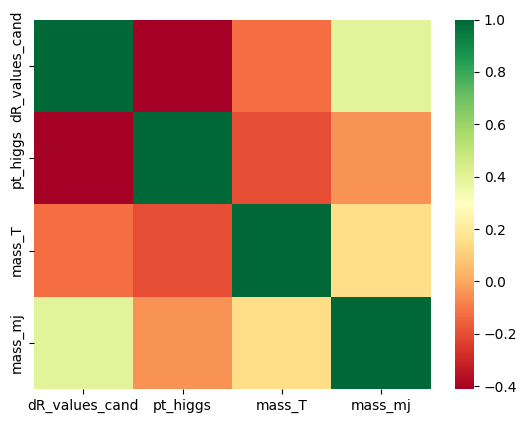

In [61]:
#train_variables = ['mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
#                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
#                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

train_variables = ['classification','dR_values_cand','pt_higgs','mass_T', 'mass_mj', 'weight']

signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(train_variables, {"signal_e" : tree_sig})

In [62]:
max_entries = 10000

train_variables = ['mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

signalMatrix = getList_ID('mc16e_signal.root', 'nominal', train_variables, max_entry = max_entries)
signalLabels = np.ones(shape = len(signalMatrix))

ttbarMatrix = getList_ID('mc16e_ttbar.root', 'nominal', train_variables, max_entry = max_entries)
ttbarLabels = np.zeros(shape = len(ttbarMatrix))

mixedMatrix = np.concatenate((signalMatrix, ttbarMatrix))
mixedLabels = np.concatenate((signalLabels, ttbarLabels))

trainMatrix1, valMatrix, trainLabels1, valLabels = train_test_split(mixedMatrix, mixedLabels, test_size = 0.1)
trainMatrix, testMatrix, trainLabels, testLabels = train_test_split(trainMatrix1, trainLabels1, test_size = 0.1)

numSig = len(signalMatrix)
numBack = len(ttbarMatrix)
totalEntries = numSig + numBack
bias = numSig / (totalEntries)
class_weight = {0: totalEntries/(2*numBack), 1: totalEntries/(2*numSig)}

In [63]:
print(trainMatrix.__getitem__(1))
print(trainMatrix[0])
#print(trainLabels)
#print(testMatrix)
#print(testLabels)

mc16e_signal1898
mc16e_ttbar3447


In [64]:
def getLabel(ID):
    if("mc16e_signal" in ID):
        return 1
    elif("mc16e_ttbar" in ID):
        return 0

trainGenerator = DataGenerator(mixedMatrix, getLabel, useWeightObj=True, weightObj=class_weight, batch_size=256, dim=14, n_channels=1, n_classes=2, shuffle=True)

valGenerator = DataGenerator(valMatrix, getLabel, useWeightObj=True, weightObj=class_weight, batch_size=256, dim=14, n_channels=1, n_classes=2, shuffle=True)

testGenerator = DataGenerator(testMatrix, getLabel, useWeightObj=True, weightObj=class_weight, batch_size=512, dim=14, n_channels=1, n_classes=2, shuffle=True)

In [65]:
print(trainGenerator[0])
print(trainGenerator[0][0])
print(trainGenerator[0][1])
print(trainGenerator[0][2])



(array([[ 0.53264645, -0.43675524,  1.24974554, ...,  0.76756148,
         1.55485147,  1.64188015],
       [ 2.39908499,  1.49322646,  1.48120572, ...,  1.2100469 ,
         1.54396553, -0.86603072],
       [-0.75455216,  1.86924436,  0.07698108, ...,  0.54597238,
        -0.82328474,  0.64869865],
       ...,
       [-0.14656425, -0.37105527, -0.8045958 , ..., -0.39771944,
         1.51752308,  0.65420672],
       [-0.22709188, -1.1521917 , -0.21835981, ..., -0.83339071,
         1.10148027,  0.20664722],
       [ 0.78812624,  0.0539556 ,  0.96046326, ...,  0.38322411,
         0.89003839, -1.65401565]]), array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1

In [66]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'),
]

nn_model = get_model(METRICS, (13,), bias)
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4)                 56        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [71]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt", save_weights_only=True, verbose=1)

nnfit = nn_model.fit(trainGenerator, validation_data = valGenerator, epochs = 400, callbacks=[early_stopping, cp_callback])

y_scores = nn_model.predict(testGenerator)
nn_model.save('sample_model.h5')

Epoch 1/400
26/26 [==============================] - ETA: 0s - loss: 0.0251 - tp: 758.0000 - fp: 531.0000 - tn: 2896.0000 - fn: 2471.0000 - accuracy: 0.5490 - precision: 0.5881 - recall: 0.2347 - auc: 0.5577 - prc: 0.5432
Epoch 1: saving model to checkpoint.ckpt
26/26 [==============================] - 4s 144ms/step - loss: 0.0251 - tp: 758.0000 - fp: 531.0000 - tn: 2896.0000 - fn: 2471.0000 - accuracy: 0.5490 - precision: 0.5881 - recall: 0.2347 - auc: 0.5577 - prc: 0.5432 - val_loss: 0.0240 - val_tp: 63.0000 - val_fp: 34.0000 - val_tn: 216.0000 - val_fn: 199.0000 - val_accuracy: 0.5449 - val_precision: 0.6495 - val_recall: 0.2405 - val_auc: 0.5911 - val_prc: 0.5912
Epoch 2/400
26/26 [==============================] - ETA: 0s - loss: 0.0253 - tp: 752.0000 - fp: 542.0000 - tn: 2889.0000 - fn: 2473.0000 - accuracy: 0.5470 - precision: 0.5811 - recall: 0.2332 - auc: 0.5552 - prc: 0.5396
Epoch 2: saving model to checkpoint.ckpt
26/26 [==============================] - 3s 113ms/step - loss

In [77]:
from wurlitzer import sys_pipes

bdt_model = boosted_decision_tree()
# bdt_model.summary()

# with sys_pipes():
#   bdt_model.fit(trainGenerator)

bdt_fit = bdt_model.fit(trainGenerator, validation_data = valGenerator, epochs = 400, callbacks=[early_stopping, cp_callback])

bdt_y_scores = bdt_model.predict(testGenerator)

Use /tmp/tmpibsbex48 as temporary training directory
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:09.027656. Found 6656 examples.
Training model...


2022-12-05 01:41:55.169093: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1765] Subsample hyperparameter given but sampling method does not match.
2022-12-05 01:41:55.169191: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1778] GOSS alpha hyperparameter given but GOSS is disabled.
2022-12-05 01:41:55.169206: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1787] GOSS beta hyperparameter given but GOSS is disabled.
2022-12-05 01:41:55.169213: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1799] SelGB ratio hyperparameter given but SelGB is disabled.
2022-12-05 01:41:55.172031: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:451] Default loss set to BINOMIAL_LOG_LIKELIHOOD
2022-12-05 01:41:55.172128: I external/ydf/yggdrasil_decision_

UnknownError: {{function_node __wrapped__SimpleMLModelTrainer_device_/job:localhost/replica:0/task:0/device:CPU:0}} TensorFlow: INVALID_ARGUMENT: Found negative weight value. [Op:SimpleMLModelTrainer]

1/1 [==============================] - 0s 360ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4)                 56        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
NN AUC:  0.4894631630348532


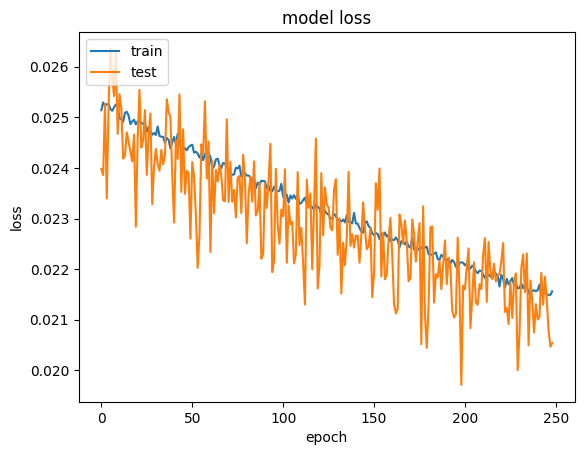

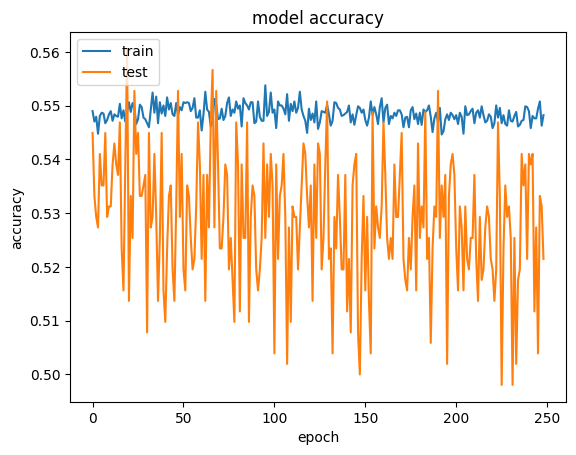

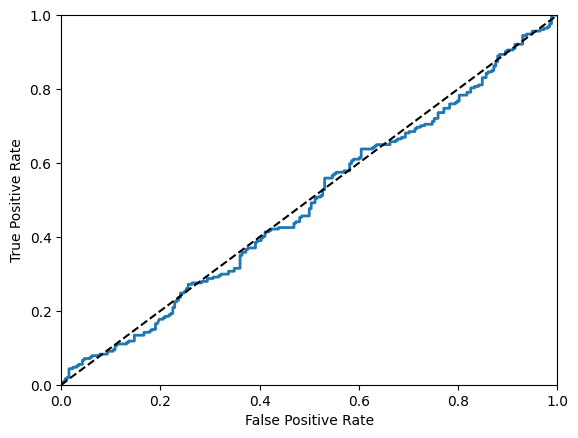

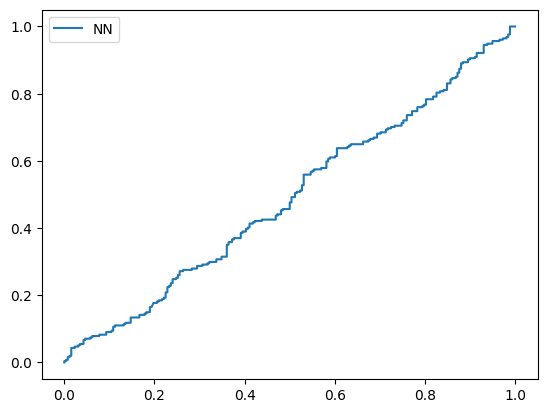

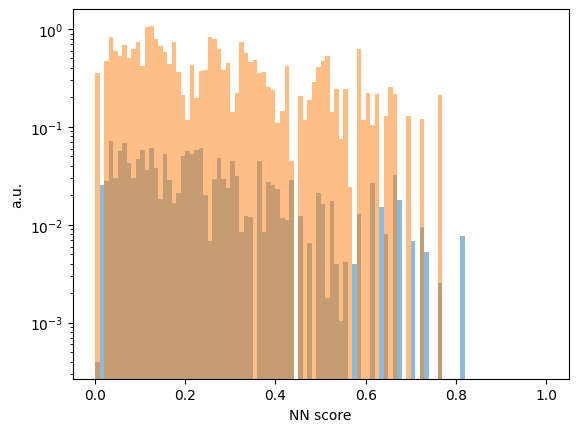

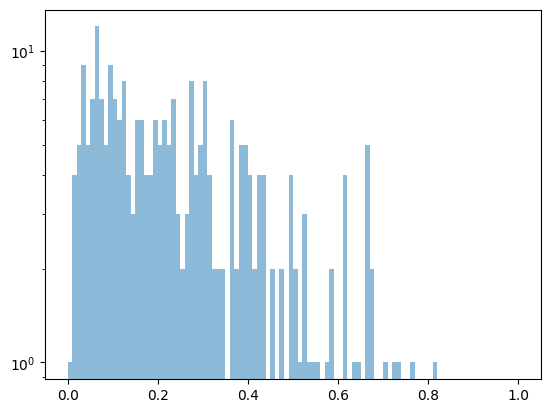

0.01692640175597914
0.26074898724833123


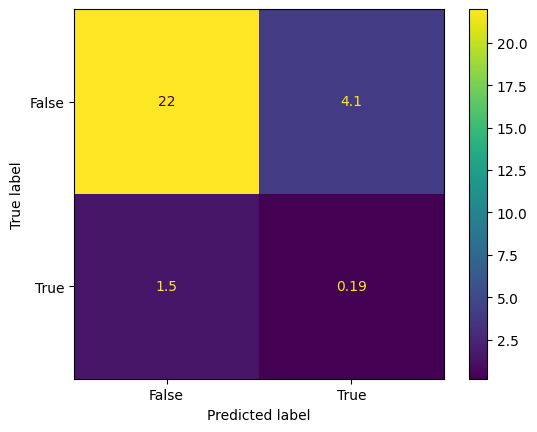

(512,)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# print(testGenerator[0])

y_scores = nn_model.predict(testGenerator)
nn_model.save('sample_model.h5')

# print(len(y_scores))
# print(len(testGenerator[0][0][0]))

# print(y_scores)

test_df = testGenerator[0][0]
test_class = testGenerator[0][1]
test_weight = testGenerator[0][2]

# print(test_df)
# print(test_class)
# print(test_weight)

# nn_model = keras.models.load_model('nn_model.h5')
# y_scores = nn_model.predict(scaled_test_df)
y_pred = np.round(y_scores)

nn_model.summary()

nn_signal_scores = y_scores[test_class == 1]
nn_background_scores = y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, y_scores)

print("NN AUC: ", auc(nn_fakes, nn_reals))

nn_loss_plot = plot_loss(nnfit)
nn_accuracy_plot = plot_accuracy(nnfit)

plot_roc_curve(nn_fakes, nn_reals)

#plot signal and background scores
plt.plot(nn_fakes, nn_reals, label="NN")
plt.legend()
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='signal', weights=test_weight[test_class == 1])
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=100, range=(0,1), alpha = 0.5, label='background', weights=test_weight[test_class == 0])
plt.xlabel('NN score')
plt.ylabel('a.u.')
plt.yscale('log')
plt.show()
plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='background')
plt.yscale('log')
plt.show()

#sum of weights
print(sum(entries * np.diff(bin_edges)))
print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

#plot all test distributions with test_class and y_pred using subplots
y_pred = y_pred.flatten()
print(y_pred.shape)
for i in range(len(test_df.columns)):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True)
    axs[0].hist(test_df[test_df.columns[i]][test_class == 0], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[test_class == 0])
    axs[0].hist(test_df[test_df.columns[i]][test_class == 1], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[test_class == 1])
    axs[0].set_xlabel(test_df.columns[i])
    axs[0].set_title('Test class')
    axs[0].legend()
    axs[1].hist(test_df[test_df.columns[i]][y_pred == 0], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[y_pred == 0])
    axs[1].hist(test_df[test_df.columns[i]][y_pred == 1], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[y_pred == 1])
    axs[1].set_xlabel(test_df.columns[i])
    axs[1].set_title('NN prediction')
    axs[1].legend()
    plt.show()
    print("")
    print("")
    plt.hist(test_df[test_df.columns[i]][test_class == 1], bins= 50, histtype='step', label='Signal_true', color='blue', weights=test_weight[test_class == 1])
    plt.hist(test_df[test_df.columns[i]][y_pred == 1], bins= 50, histtype='step', label='Signal_pred', color='red', weights=test_weight[y_pred == 1])
    plt.xlabel(test_df.columns[i])
    plt.legend()
    plt.show()
    print("")
    print("")
    # plt.hist(test_df[test_df.columns[i]][(test_class == 0) & (y_pred == 0)], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[(test_class == 0) & (y_pred == 0)])
    entries2, bin_edges2, c2 = plt.hist(test_df[test_df.columns[i]][(test_class == 1) & (y_pred == 1)], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[(test_class == 1) & (y_pred == 1)])
    plt.xlabel(test_df.columns[i])
    plt.legend()
    plt.show()
    print(sum(entries2))


In [ ]:
def hiWeightVars(model, inVars):
    model_weights = model.layers[0].get_weights()[0]
    if('classification' in inVars):
        inVars.remove('classification')
    if('weight' in inVars):
        inVars.remove('weight')
    model_weights = [np.mean([abs(weight) for weight in weights]) for weights in model_weights]
    
    a = zip(model_weights, inVars)
    b = sorted(a)
    model_weights, inVars = zip(*b)

    for i in range(len(model_weights)):
        print(str(inVars[i]) + ": " + str(model_weights[i]))

hiWeightVars(nn_model, train_variables)



mueta_cand: 0.16002351
muphi_cand: 0.18046325
ljet_pt_cand: 0.19509485
met_phi: 0.21438567
mass_mj: 0.28379577
mupt_cand: 0.29799345
ljet_phi_cand: 0.30252308
mass_T: 0.31369695
ljet_eta_cand: 0.35461175
dR_values_cand: 0.3590666
pt_higgs: 0.3704209
ljet_mass_cand: 0.37326616
met_met: 0.401074


In [ ]:
probability_model = tf.keras.Sequential([nn_model, tf.keras.layers.Softmax()])
predictions = nn_model.predict(testGenerator[0][0])
print(predictions)

8/8 [==============================] - 0s 2ms/step
[[0.50128454 0.4963157 ]
 [0.97932845 0.9771987 ]
 [0.8643316  0.7468014 ]
 [0.91545    0.6924078 ]
 [0.8394927  0.687058  ]
 [0.83755374 0.5175192 ]
 [0.640758   0.6465434 ]
 [0.90286225 0.6040088 ]
 [0.87116736 0.5244425 ]
 [0.9325398  0.57892627]
 [0.6024543  0.46521288]
 [0.76312405 0.71444637]
 [0.85875124 0.8177056 ]
 [0.71272844 0.70370287]
 [0.8300963  0.53513   ]
 [0.787357   0.38734102]
 [0.88638246 0.6541037 ]
 [0.63799673 0.47185093]
 [0.53652894 0.5339829 ]
 [0.8579109  0.42137048]
 [0.52639204 0.5184237 ]
 [0.76835924 0.52304804]
 [0.8577261  0.8710656 ]
 [0.78026605 0.75332105]
 [0.7701825  0.7484358 ]
 [0.816429   0.5475472 ]
 [0.50128454 0.4963157 ]
 [0.8160762  0.59829277]
 [0.79660636 0.76533294]
 [0.50128454 0.4963157 ]
 [0.8438023  0.83609354]
 [0.89019257 0.7804105 ]
 [0.7575612  0.59437925]
 [0.7380238  0.47398674]
 [0.86866474 0.67824876]
 [0.82038105 0.6802491 ]
 [0.6259334  0.45129293]
 [0.8167648  0.544914  ]

In [ ]:
#nn_model = get_model((14,))
# #fit the model to train on all but the last column
#print("MATT, FITTING MODEL")
#callback = LearningRateScheduler(custom_LearningRate_schedular)
# print(train_dataset[:,train_dataset.shape[1]-1 : train_dataset.shape[1]])
#nn_fit = nn_model.fit(train_dataset[:, 0:train_dataset.shape[1]-1], train_output, epochs=500, batch_size = 500, validation_data=(val_dataset[:, 0:train_dataset.shape[1]-1], val_output), sample_weight=train_dataset[:,train_dataset.shape[1]-1 : train_dataset.shape[1]], shuffle=True)
# validation_data=(val_dataset[:, 0:train_dataset.shape[1]-1], val_output),
# print(train_dataset[:,0:train_dataset.shape[1]-1])
# nn_fit = nn_model.fit(train_dataset[:,0:train_dataset.shape[1]-1], train_output[:,0:0:train_dataset.shape[1]-1], epochs=70, batch_size=500, verbose=1, shuffle=True, validation_data=(val_dataset[:,0:train_dataset.shape[1]-1], val_output[:,0:train_dataset.shape[1]-1]), sample_weight=train_dataset[:,train_dataset.shape[1]-1:train_dataset.shape[1]])
#print("MATT, MODEL FITTED")
#print("MATT, PREDICTING")
#y_scores = nn_model.predict(test_dataset[:, 0:train_dataset.shape[1]-1])



#bdt_model = boosted_decision_tree()
#print("MATT, FITTING MODEL")
#bdt_fit = bdt_model.fit(train_dataset[:, 0:train_dataset.shape[1]-1], train_output, sample_weight=train_dataset[:,train_dataset.shape[1]-1 : train_dataset.shape[1]])
#print("MATT, MODEL FITTED")
#print("MATT, PREDICTING")
#bdt_y_scores = bdt_model.predict(test_dataset[:, 0:train_dataset.shape[1]-1])


In [ ]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class CIFAR10Sequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)

In [ ]:
genObj = CIFAR10Sequence([1, 2, 3, 4, 5], [1, 4, 9, 16, 25], 2)

In [ ]:
testingModel = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(1,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(62, activation='softmax')
])

